In [53]:
import os
import torch
import numpy as np
from emcee import EnsembleSampler
from src.flow import NormFlow
from getdist import plots, MCSamples
import getdist
import matplotlib.pylab as plt 
from typing import Any 
import dill 
import pandas as pd 

plt.rc("text", usetex=True)
plt.rc("font", **{"family": "sans-serif", "serif": ["Palatino"]})
FONTSIZE = 20

In [42]:
COLS_tau = ['sigma8', 'Omega_cdm', 'Omega_b', 'h', 'n_s', 'tau'] 

# Processing

In [ ]:
def process_oxford_tau_planck_2018(save=False, burnin=None, thin = None):
    fname = 'P18_lcdm_nu'
    columns = [30, 3, 4, 5, 6, 7]
    record = []
    for i in range(6):
        samples = np.loadtxt(f'originalsamples/{fname}/{fname}.{i+1}.txt')
        cosmologies = samples[:,columns]
        if burnin is not None:
            start = int(cosmologies.shape[0] * burnin)
            cosmologies = cosmologies[start:]
        if thin is not None:
            cosmologies = cosmologies[0::thin]
        record.append(cosmologies)
    record = np.concatenate(record)
    df = pd.DataFrame(record, columns=COLS_tau)
    print(f'Total number of samples for Oxford Planck 2018 is: {df.shape[0]}')
    if save:
        df.to_csv(f'samples/{fname}_tau.csv')
    return df

In [ ]:
training_points = process_oxford_tau_planck_2018(save=False, burnin=0.25)

# Training

In [ ]:
fname = 'P18_lcdm_nu_tau'
flow_folder = 'flows'
flow = NormFlow(fname, 25000)

In [ ]:
# loss = flow.training(lr=1E-3, nsteps=3000)
# torch.save(flow, f"{flow_folder}/{fname}.pt")

In [52]:
def triangle_cosmology(
    samples1: np.ndarray, samples2: np.ndarray, label1: str, label2: str, fname: str = None
):
    """Creates a triangle plot given the original samples and the flow samples.

    Args:
        samples1 (np.ndarray): the original samples
        samples2 (np.ndarray): the flow samples
        label1 (str): label for the first set of samples
        label2 (str): label for the second set of samples
        fname (str): name of the file for output
    """

    settings = {
        "mult_bias_correction_order": 0,
        "smooth_scale_2D": 0.3,
        "smooth_scale_1D": 0.3,
    }
    color2 = "#50C878"
    color1 = "#222E50"

    ndim = 6
    names = ["x%s" % i for i in range(ndim)]
    labels = [r"$\sigma_{8}$", r"$\Omega_{c}$", r"$\Omega_{b}$", r"$h$", r"$n_{s}$", r"$\tau$"]

    samples_1 = MCSamples(
        samples=samples1, names=names, labels=labels, label=label1, settings=settings
    )
    samples_2 = MCSamples(
        samples=samples2, names=names, labels=labels, label=label2, settings=settings
    )

    G = plots.getSubplotPlotter(subplot_size=1.0)
    G.settings.solid_contour_palefactor = 0.9
    G.settings.alpha_filled_add = 0.9
    G.settings.num_plot_contours = 2
    G.settings.lw_contour = 1
    G.settings.axes_fontsize = 15
    G.settings.lab_fontsize = 15
    G.settings.fontsize = 35
    G.settings.legend_fontsize = 14
    samples_1.updateSettings({"contours": [0.68, 0.95]})
    samples_2.updateSettings({"contoburs": [0.68, 0.95]})
    G.triangle_plot(
        [samples_2, samples_1],
        filled=[True, False],
        contour_colors=[color2, color1],
        contour_lws=[2, 2],
        contour_ls=["-", "-"],
        legend_loc=(0.45, 0.88),
    )
    plt.show()

In [ ]:
# flow_samples = flow.generate_samples(50000)
# triangle_cosmology(testing.values, flow_samples, 'Planck', 'Planck (flow)')

# Sampling 

In [24]:
def load_flow(experiment: str) -> NormFlow:
    """Load a pre-trained normalising flow.

    Args:
        experiment (str): name of the experiment (flow)

    Returns:
        NormFlow: the pre-trained normalising flow
    """
    flow = torch.load(f"flows/{experiment}.pt")
    return flow


def loglike_flows(sample, flows):

    keys = list(flows.keys())
    logl = 0.0
    for key in keys:
        if 'P18' in key:
            logl += flows[key].loglike(sample).item()
        else:
            logl += flows[key].loglike(sample[0:5]).item()
    return logl

In [57]:
fname_1 = 'P18_lcdm_nu_tau'
fname_2 = 'FD_Garcia-Garcia2021_dzMarg_mMarg_nu'
flows = {fname_1: load_flow(fname_1), fname_2: load_flow(fname_2)}

In [58]:
cosmology = np.array([0.811, 0.264, 0.049, 0.673, 0.964, 0.054])

In [62]:
flows[fname_1].loglike(cosmology).item()

30.347881317138672

In [63]:
flows[fname_2].loglike(cosmology[0:5]).item()

-4.281316757202148

In [59]:
loglike_flows(cosmology, flows)

26.066564559936523

In [28]:
class SampleFlow:
    """Draw samples from the joint, given a list of experiments.

    Args:
        experiments (list): a list of experiments we want to use.
    """

    def __init__(self, experiments: list):

        self.flows = {e: load_flow(e) for e in experiments}
        self.nexp = len(self.flows)
        self.mean = self.flows[experiments[0]].samples.mean(0)
        self.ndim = len(self.mean)
        self.nwalkers = 2 * self.ndim

    def sampler(self, nsamples: int, eps: float) -> EnsembleSampler:
        """Sample the joint using emcee.

        Args:
            nsamples (int): the number of samples we want
            eps (float): the step-size to use in emcee.

        Returns:
            EnsembleSampler: the emcee Ensemble sampler
        """
        pos = self.mean + eps * np.random.randn(self.nwalkers, self.ndim)
        sampler = EnsembleSampler(
            self.nwalkers, self.ndim, loglike_flows, args=(self.flows,)
        )
        sampler.run_mcmc(pos, nsamples, progress=True)
        return sampler

In [29]:
testing = SampleFlow([fname_1, fname_2])

In [35]:
sampler = testing.sampler(10000, 1E-3)

100%|██████████████████████████████████████████████████████████████| 10000/10000 [17:53<00:00,  9.31it/s]


In [38]:
def dill_save(file: Any, fname: str) -> None:
    """Stores a file, for example, MCMC samples.
    Args:
        file (Any): the file we want to store.
        fname (str): the name of the file.
    """

    # get the folder where the files are stored
    folder = 'mcmcsamples/'

    # use compressed format to store data
    path = os.path.join(folder, fname)
    with open(path + ".pkl", "wb") as dummy:
        dill.dump(file, dummy)

In [39]:
# dill_save(sampler, 'P18_tau_FD')

In [41]:
mcmc_samples_flow = sampler.get_chain(flat=True, discard=500)

In [49]:
def process_samples_FD_P18(burnin=None, thin=None):
    fname = 'FD_Garcia-Garcia2021_dzMarg_mMarg_P18_lcdm_nu' 
    columns = [-12, 3, 4, 5, 6, 7]
    record = []
    for i in range(4):
        samples = np.loadtxt(f'originalsamples/{fname}/{fname}.{i+1}.txt')
        cosmologies = samples[:,columns]
        if burnin is not None:
            start = int(cosmologies.shape[0] * burnin)
            cosmologies = cosmologies[start:]
        if thin is not None:
            cosmologies = cosmologies[0::thin]
        record.append(cosmologies)
    record = np.concatenate(record)
    df = pd.DataFrame(record, columns=COLS_tau)
    print(f'Total number of samples for Oxford Full Dataset + Planck is: {df.shape[0]}')
    return df

In [51]:
original_samples = process_samples_FD_P18(burnin=0.25)

Total number of samples for Oxford Full Dataset + Planck is: 34679


Removed no burn in
Removed no burn in


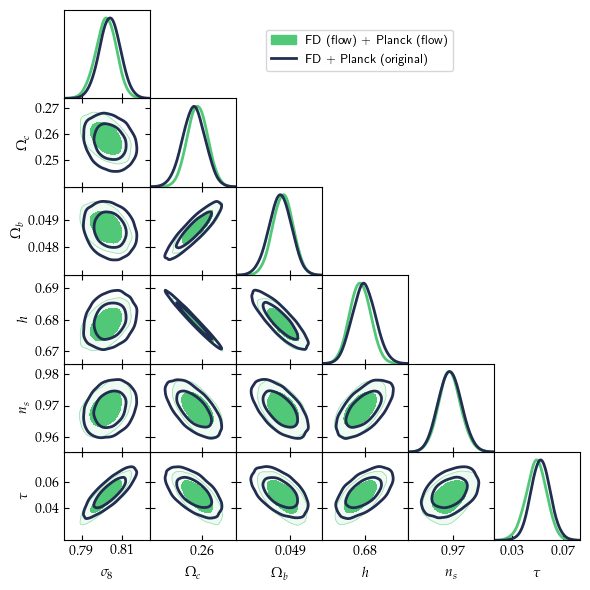

In [54]:
triangle_cosmology(original_samples.values, mcmc_samples_flow, 'FD + Planck (original)', 'FD (flow) + Planck (flow)')